<a href="https://colab.research.google.com/github/recozers/Teleco_churn/blob/main/Telecom_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [86]:
import csv
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from pygam import LogisticGAM, s, f

Import data and take a look

In [87]:
data = pd.read_csv("data.csv")
print(data.head)

<bound method NDFrame.head of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL   

Main assumptions for linear regression:
1. Linear relationship: difficult to visualise with a binary variable
2. No multicolinearity: Correlations between features
3. Constant variance: Does increased values of a feature lead to more variance in outcome variable

This is not a good scatterplot


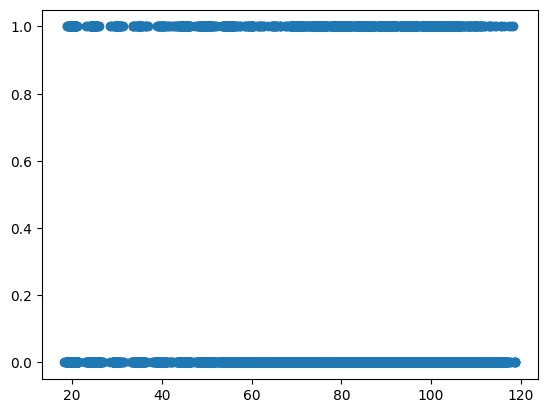

In [88]:
data['Churn_Binary'] = data['Churn'].map({'Yes': 1, 'No': 0})

plot.scatter(data['MonthlyCharges'], data['Churn_Binary'])
print("This is not a good scatterplot")

This plot is obviously uselss so we need a better way of visualising the data

Lets look at some variables and their impact on the target variable (churn)

Testing gender


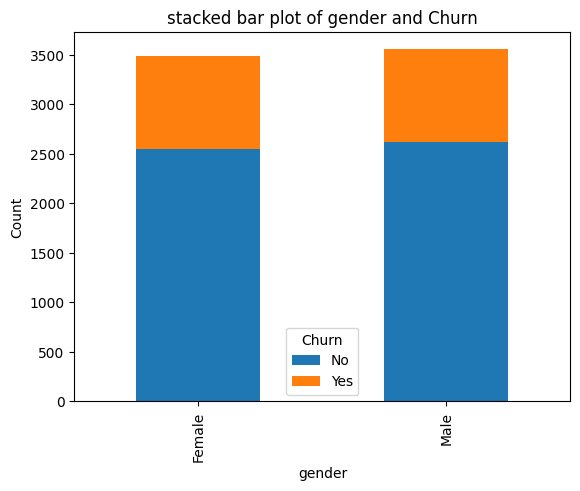

Chi-Square Statistic: 0.4840828822091383, p-value: 0.48657873605618596
Testing SeniorCitizen


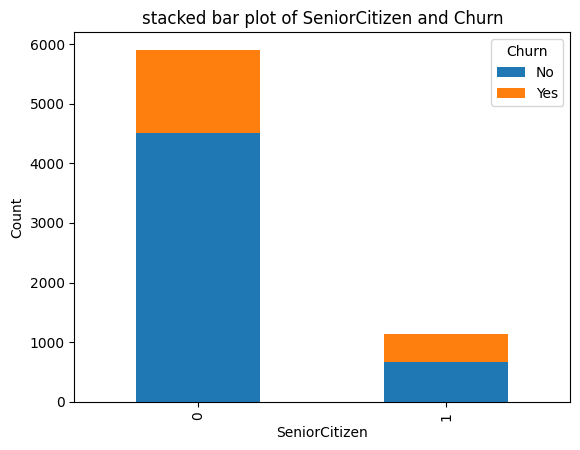

Chi-Square Statistic: 159.42630036838742, p-value: 1.510066805092378e-36
Testing Partner


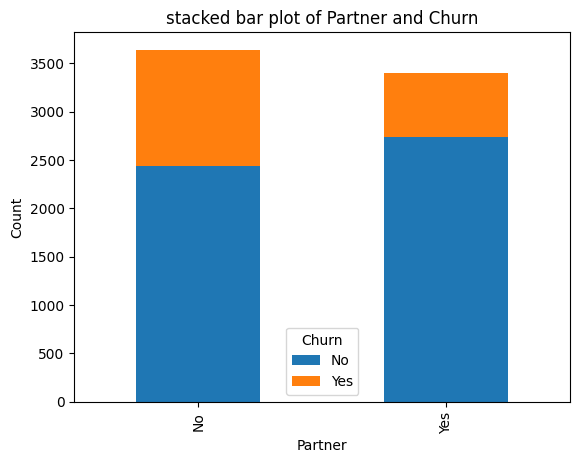

Chi-Square Statistic: 158.7333820309922, p-value: 2.1399113440759935e-36
Testing Dependents


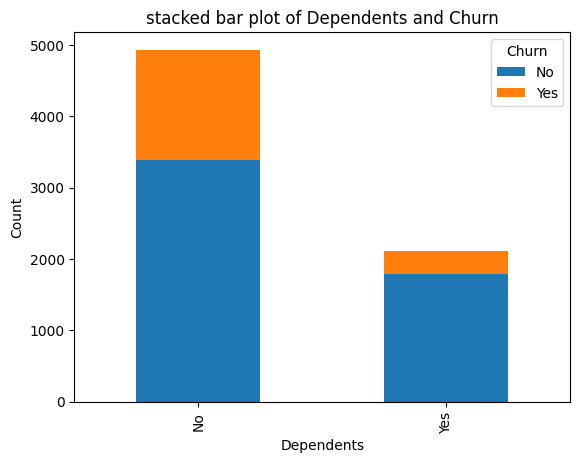

Chi-Square Statistic: 189.12924940423474, p-value: 4.9249216612154196e-43


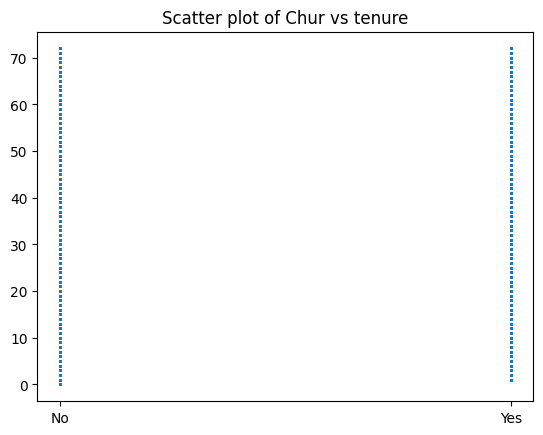

Testing PhoneService


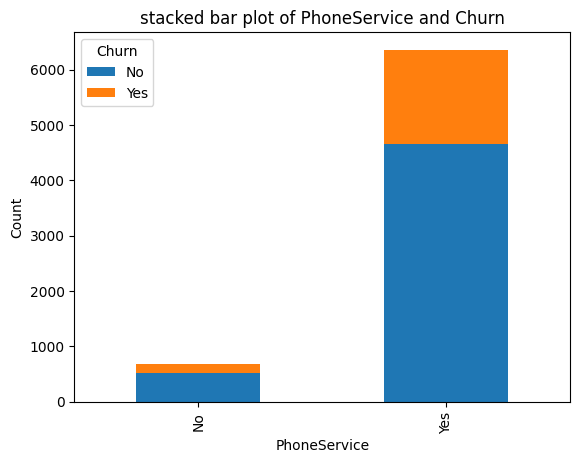

Chi-Square Statistic: 0.9150329892546948, p-value: 0.3387825358066928
Testing MultipleLines


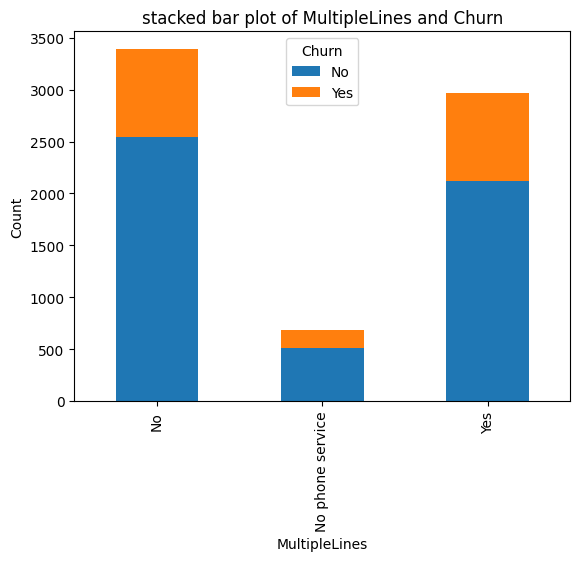

Chi-Square Statistic: 11.33044148319756, p-value: 0.0034643829548773
Testing InternetService


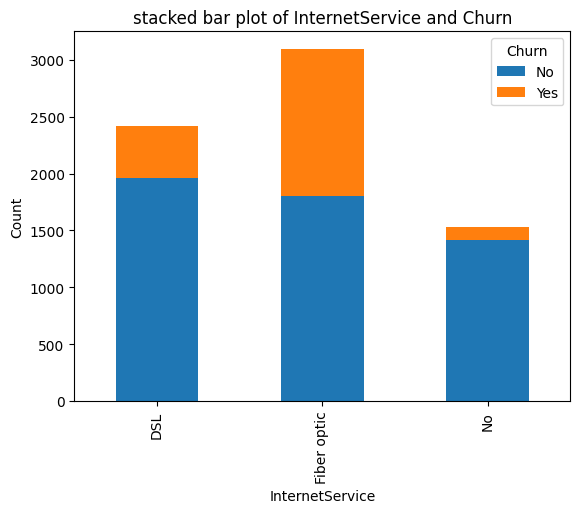

Chi-Square Statistic: 732.309589667794, p-value: 9.571788222840544e-160
Testing OnlineSecurity


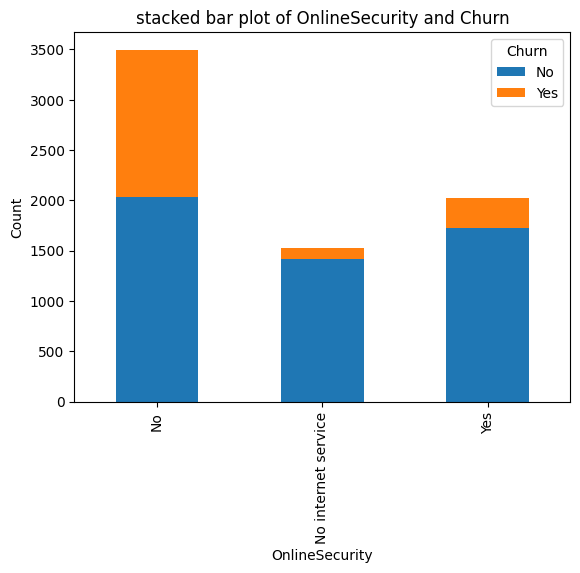

Chi-Square Statistic: 849.9989679615965, p-value: 2.661149635176552e-185
Testing OnlineBackup


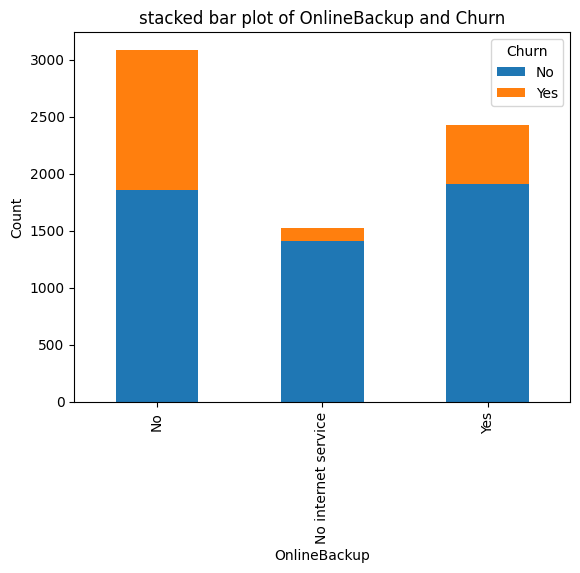

Chi-Square Statistic: 601.812790113409, p-value: 2.0797592160864276e-131
Testing DeviceProtection


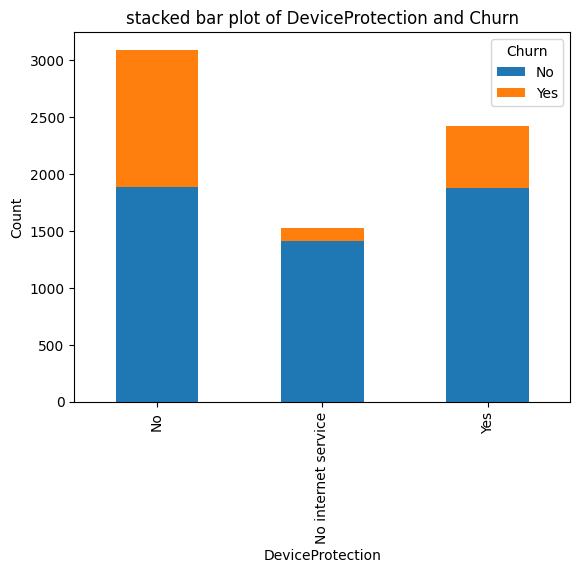

Chi-Square Statistic: 558.419369407389, p-value: 5.505219496457244e-122
Testing TechSupport


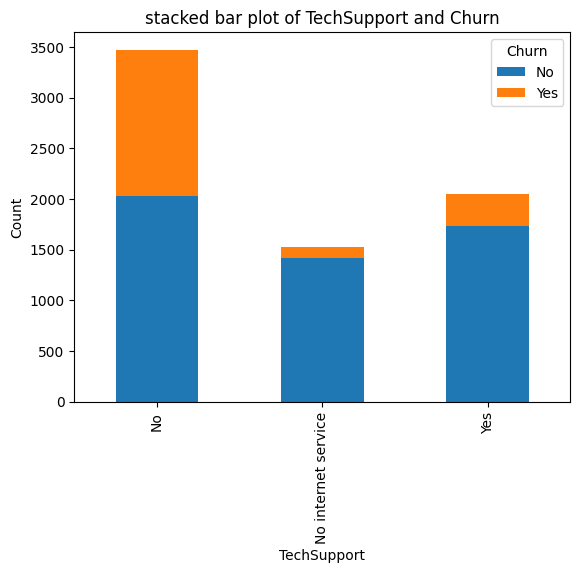

Chi-Square Statistic: 828.1970684587394, p-value: 1.4430840279998987e-180
Testing StreamingTV


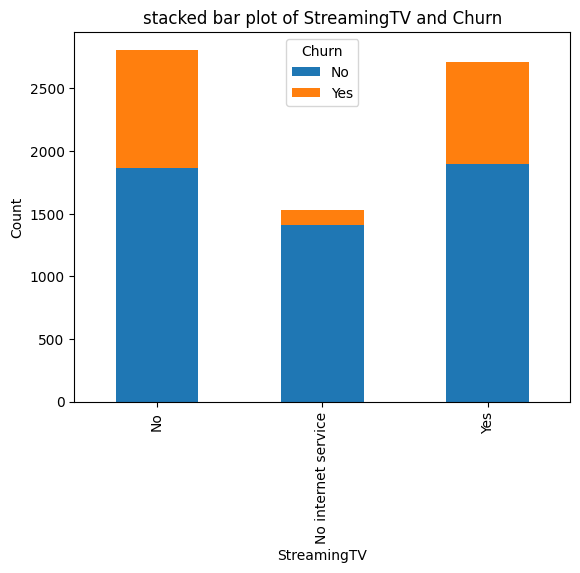

Chi-Square Statistic: 374.2039433109813, p-value: 5.528994485739183e-82
Testing StreamingMovies


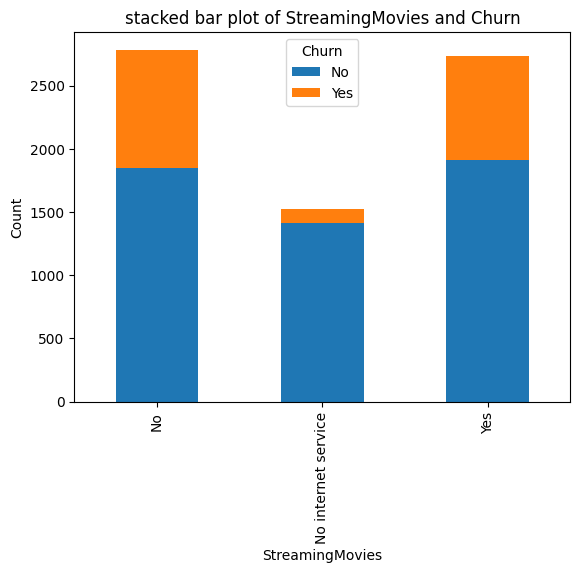

Chi-Square Statistic: 375.6614793452656, p-value: 2.667756755723681e-82
Testing Contract


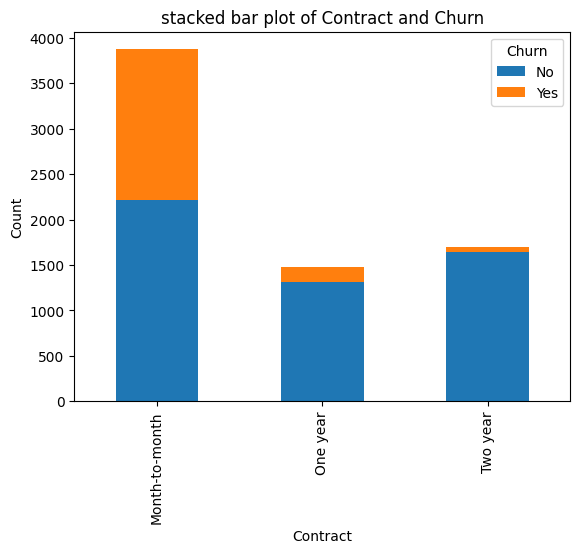

Chi-Square Statistic: 1184.5965720837926, p-value: 5.863038300673391e-258
Testing PaperlessBilling


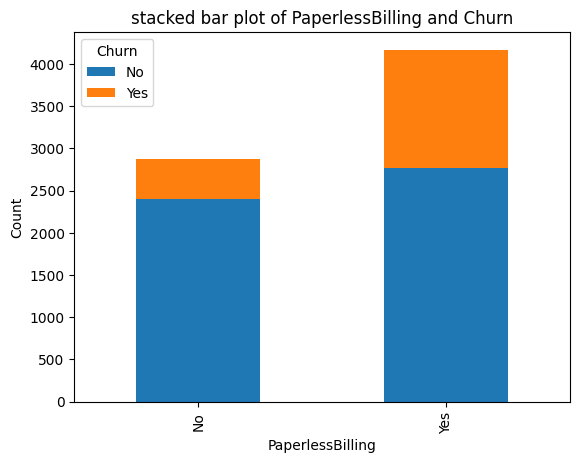

Chi-Square Statistic: 258.27764906707307, p-value: 4.073354668665985e-58
Testing PaymentMethod


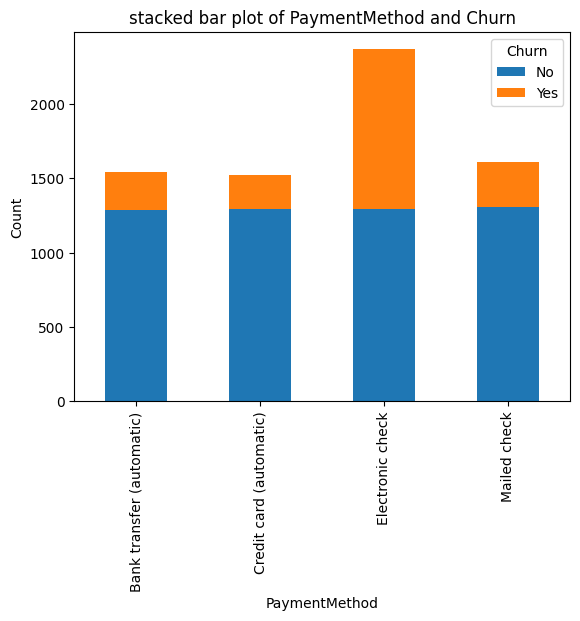

Chi-Square Statistic: 648.1423274814, p-value: 3.6823546520097993e-140


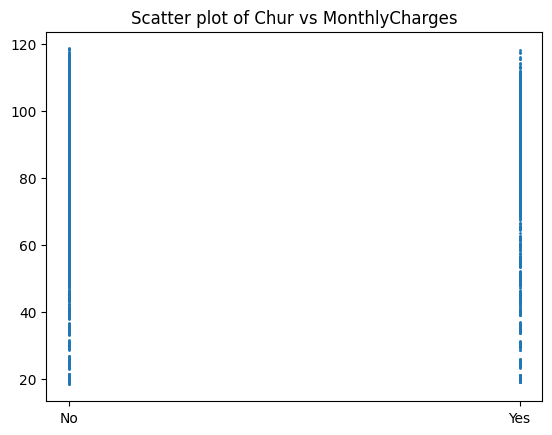

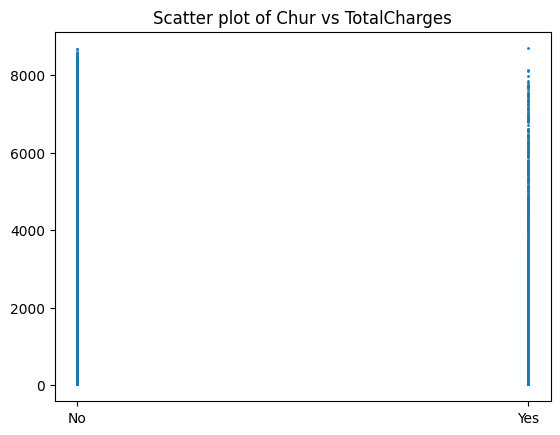

In [89]:
data_chi = data.drop(labels= ["Churn","Churn_Binary","customerID"], axis = 1, inplace = False)
data_chi['TotalCharges'] = pd.to_numeric(data_chi['TotalCharges'], errors='coerce')

for col in data_chi.columns:
  if data_chi[col].dtype == 'object' or col == "SeniorCitizen":
    print("Testing", col)
    contingencytable = pd.crosstab(data_chi[col],data['Churn'])

    contingencytable.plot(kind='bar', stacked=True)

    plot.title("stacked bar plot of " + col + " and Churn")
    plot.xlabel(col)
    plot.ylabel("Count")
    plot.show()

    chi2_stat, p_val, dof, expected = chi2_contingency(contingencytable)

    print(f"Chi-Square Statistic: {chi2_stat}, p-value: {p_val}")
  elif data_chi[col].dtype in ['int64', 'float64']:
    plot.scatter(data["Churn"], data_chi[col], s = 1)
    plot.title("Scatter plot of Churn vs " + col)
    plot.show()

  else:

    plot.bar(data["Churn"], data_chi[col])
    plot.title("Bar plot of " + col + " and Churn")
    plot.xlabel("Churn")
    plot.ylabel(col)
    plot.show()



For the chi square test, a higher value indicates a greater deviation from independence. Its not particularly surprising that total charges is dependent on churn, if youve been charged a lot you havent left in previous months which one would assume would make you less likely to leave the next. The same goes for contract length. Churn seems to be mostly independent of Gender.

Lets check for multicolinearity

In [90]:
from sklearn.preprocessing import LabelEncoder

corr_data = data.drop(labels='Churn_Binary', axis=1, inplace=False)

le = LabelEncoder()

for col in corr_data:
    corr_data[col] = le.fit_transform(corr_data[col])

correlation_matrix = corr_data.corr()

np.fill_diagonal(correlation_matrix.values, np.nan)

above_thresh = correlation_matrix[correlation_matrix > 0.5]

above_thresh = above_thresh.stack()

print(above_thresh)

tenure    Contract    0.671607
Contract  tenure      0.671607
dtype: float64


The correlation matrix suggests the only correlated terms are Contract and tenure. We can either drop them or place less emphasis on their coefficients in the analysis. Technically i am intorudcing some bias when there are multiple options and the data isn't ordinal. But this doesn't seem to have impacted the anlysis.

# Linear model


Prep data

In [91]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
cols = []
data_train = data.drop(labels = ['customerID'], axis = 1, inplace = False)

for col in data_train:
  if data[col].dtype == 'object':
    cols.append(col)

data_train = pd.get_dummies(data_train, columns = cols, drop_first = True)

print(data_train.head)

<bound method NDFrame.head of       SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn_Binary  \
0                 0       1           29.85         29.85             0   
1                 0      34           56.95       1889.50             0   
2                 0       2           53.85        108.15             1   
3                 0      45           42.30       1840.75             0   
4                 0       2           70.70        151.65             1   
...             ...     ...             ...           ...           ...   
7038              0      24           84.80       1990.50             0   
7039              0      72          103.20       7362.90             0   
7040              0      11           29.60        346.45             0   
7041              1       4           74.40        306.60             1   
7042              0      66          105.65       6844.50             0   

      gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0

In [92]:
data_train = data_train.dropna()

X = data_train.drop(columns = ["Churn_Yes", "Churn_Binary"], axis = 1)
y = data_train["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()

model.fit(X_train, y_train)

pred = model.predict(X_test)

mse = mean_squared_error(y_test, pred)

pred_binary = [1 if p >= 0.5 else 0 for p in pred] #could adjust this for sensitivity

acc = accuracy_score(y_test, pred_binary)

print("Accuray of:",str(acc*100) + "%", "mse:", mse)
print(classification_report(pred_binary, y_test))

Accuray of: 81.02345415778251% mse: 0.13606170224086125
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1109
           1       0.54      0.72      0.62       298

    accuracy                           0.81      1407
   macro avg       0.73      0.78      0.75      1407
weighted avg       0.84      0.81      0.82      1407



80% accuray is pretty good and mse looks relatively good, but we really care about predicting true for churn, and for that we only have ~53% accuracy. lets take a look at the weights.

In [93]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print(coef_df)

                                  Feature  Coefficient
0                           SeniorCitizen     0.041434
1                                  tenure    -0.002119
2                          MonthlyCharges    -0.000552
3                            TotalCharges    -0.000043
4                             gender_Male     0.004284
5                             Partner_Yes    -0.005926
6                          Dependents_Yes    -0.018050
7                        PhoneService_Yes    -0.009739
8          MultipleLines_No phone service     0.009739
9                       MultipleLines_Yes     0.052108
10            InternetService_Fiber optic     0.185789
11                     InternetService_No    -0.020518
12     OnlineSecurity_No internet service    -0.020518
13                     OnlineSecurity_Yes    -0.041848
14       OnlineBackup_No internet service    -0.020518
15                       OnlineBackup_Yes    -0.012602
16   DeviceProtection_No internet service    -0.020518
17        

Looks like having fiber optic internet is a strong driver of Churning, and being on a longer contract drives you away from churning. But remember COntract and tenure were correlated so this could be misleading.

# Logistic Regression

In [96]:
X = data_train.drop(columns = ["Churn_Yes", "Churn_Binary"], axis = 1)
y = data_train["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

acc = accuracy_score(pred, y_test)

print("Classification report")
print(classification_report(pred, y_test))
print("Model accuracy:", str(acc*100) + "%")

Classification report
              precision    recall  f1-score   support

       False       0.89      0.85      0.87      1093
        True       0.55      0.64      0.59       314

    accuracy                           0.80      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.82      0.80      0.81      1407

Model accuracy: 80.38379530916845%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Looks like the mdoel is about the same accuracy, lets have a look at these weights.

In [97]:
coefficients = model.coef_.flatten()

coef_df = pd.DataFrame({
    'Feature': X.columns,                    # Features
    'Coefficient (log-odds)': coefficients,  # Coefficients
    'Odds': np.exp(coefficients)             #odds
})

print(coef_df)

                                  Feature  Coefficient (log-odds)      Odds
0                           SeniorCitizen                0.308397  1.361242
1                                  tenure               -0.073905  0.928760
2                          MonthlyCharges                0.005039  1.005052
3                            TotalCharges                0.000407  1.000407
4                             gender_Male               -0.013791  0.986304
5                             Partner_Yes               -0.051618  0.949691
6                          Dependents_Yes               -0.185189  0.830947
7                        PhoneService_Yes               -0.274137  0.760228
8          MultipleLines_No phone service                0.113806  1.120535
9                       MultipleLines_Yes                0.225982  1.253553
10            InternetService_Fiber optic                0.422912  1.526400
11                     InternetService_No               -0.124533  0.882909
12     Onlin

This is slightly less intuitive to interpret, and given its accuracy is similar to linear regression I would prefer that at this stage.

# GAM

In [98]:
X = data_train.drop(columns = ["Churn_Yes", "Churn_Binary"], axis = 1)
y = data_train["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

gam_formula = None

# Iterate over the columns and assign s() or f() based on the column type
for i, col in enumerate(X.columns):
    if col in numerical_cols:
        term = s(i)
    else:
        term = f(i)
    if gam_formula is None:
        gam_formula = term
    else:
        gam_formula += term

my_gam = LogisticGAM(gam_formula)

my_gam.fit(X_train, y_train)

pred = my_gam.predict(X_test)

acc = accuracy_score(y_test, pred)

print("Model accuracy:", str(acc*100) + "%")

print(classification_report(pred, y_test))

Model accuracy: 80.45486851457001%
              precision    recall  f1-score   support

       False       0.91      0.84      0.87      1124
        True       0.51      0.68      0.58       283

    accuracy                           0.80      1407
   macro avg       0.71      0.76      0.73      1407
weighted avg       0.83      0.80      0.81      1407



This model appears to be slighly more accurate, but interpreting the coefficients would be a lot more difficult, not impossible but quite technical.

# Model Choice

As with a lot of choices in machine learning we have a choice between model accuracy and model interpretability. To make an informed decision lets consider the client: Telco. Telco want to use this model to reduce churn, they need to understand why customers are churning and make changes to that feature. Thus interpretability is more important than accuracy. For this reason I would reccomend Linear Regression. It is the easiest to interpret and the increased accuracy is minimal over the more complex models. All the models are actually relatively poor at predicting the positive value for Churn and so Telco may be better off looking at why customers dont churn, as opposed to why they do.